In [46]:
import pandas as pd

from medmodels.medrecord import MedRecord
from medmodels.statistic_evaluations.evaluate_compare.compare import CohortComparer
from medmodels.statistic_evaluations.evaluate_compare.evaluate import CohortEvaluator

# Load MedRecords

In [30]:
data_dir = "/Users/martin.iniguez/Desktop/projects/medmodels/data/40000/"
medrecord = MedRecord.from_ron(data_dir + "mimic_medrecord.ron")
synthetic_medrecord = MedRecord.from_ron(data_dir + "synthetic_medrecord.ron")

In [32]:
medrecord

----------------------------------------------------------------
Nodes Group   Count Attribute   Type         Data               
----------------------------------------------------------------
diagnoses     3365  icd_version Continuous   min: 9             
                                             max: 10            
                                             mean: 9.54         
patients      9795  anchor_age  Continuous   min: 18            
                                             max: 91            
                                             mean: 58.72        
                    gender      Categorical  Categories: F, M   
prescriptions 3239  gsn         Unstructured 1498 unique values 
procedures    725   icd_version Continuous   min: 9             
                                             max: 10            
                                             mean: 9.45         
----------------------------------------------------------------

------------------------

# Evaluate Cohorts

Create evaluator for sub cohorts in the MedRecord. 

Inside the Evaluator a copy of the medrecord is made with the smaller groups and the concept edges will be added for faster calculations later.

In [36]:
# creating CohortEvaluators from the same MedRecord doesn't need much
evaluator_mimic = CohortEvaluator(
    medrecord, name="Original MedRecord", patient_group="patients"
)

Getting concept counts: 100%|██████████| 3365/3365 [29:19<00:00,  1.91it/s]
Getting concept counts: 0it [00:00, ?it/s]


In [5]:
evaluator_synthetic = CohortEvaluator(
    synthetic_medrecord, name="Synthetic MedRecord", patient_group="patients"
)

Getting concept counts: 100%|██████████| 3365/3365 [11:43<00:00,  4.78it/s]
Getting concept counts: 0it [00:00, ?it/s]


## Summary of the attributes of a group

In [48]:
# Summary dict with patients and their concepts and some descriptive stats
summary_diagnoses = evaluator_mimic.attribute_summary["diagnoses"]
pd.DataFrame(summary_diagnoses)

,time
type,Temporal
min,2110-01-12 22:28:00
max,2214-09-30 21:29:00
mean,2157-02-20 20:56:48.978404
median,2157-02-13 12:10:00
Q1,2137-03-16 14:00:00
Q3,2177-04-21 16:00:00


## Show which concepts are the most repeated

In [49]:
# can retrieve the top k concepts from all types
evaluator_synthetic.get_top_k_concepts(10, concept="diagnoses")

[('4019', 6692),
 ('E785', 6386),
 ('2724', 4765),
 ('Z87891', 4474),
 ('I10', 4087),
 ('53081', 3260),
 ('25000', 2693),
 ('V1582', 2509),
 ('K219', 2370),
 ('311', 2369)]

# Compare cohorts

Input for all Comparer functions are the CohortEvaluators.

## Compare cohort attributes


In [50]:
# compare one cohort attribute for different cohorts
age_comparison = CohortComparer.compare_cohort_attribute(
    cohorts=[evaluator_synthetic, evaluator_mimic], attribute="anchor_age"
)
pd.DataFrame(age_comparison)

,Synthetic MedRecord,Original MedRecord
type,Continuous,Continuous
min,18,18
max,91,91
mean,54.777131,58.723941
median,56.0,61.0
Q1,40.0,45.0
Q3,68.0,73.0


Text(0, 0.5, 'Frequency')

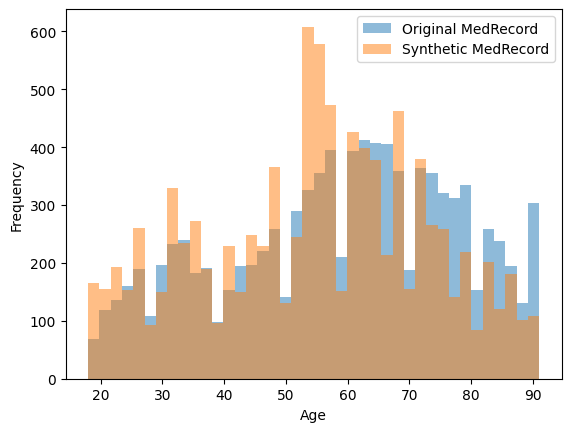

In [51]:
age_medrecord = np.array(list(medrecord.node[lambda node: node.in_group("patients"), "anchor_age"].values()))
age_synthetic = np.array(list(synthetic_medrecord.node[lambda node: node.in_group("patients"), "anchor_age"].values()))
plt.hist(age_medrecord, bins=40, alpha=0.5, label="Original MedRecord")
plt.hist(age_synthetic, bins=40, alpha=0.5, label="Synthetic MedRecord")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")

In [52]:
# compare one cohort attribute for different cohorts
gender_comparison = CohortComparer.compare_cohort_attribute(
    cohorts=[evaluator_synthetic, evaluator_mimic], attribute="gender"
)
pd.DataFrame(gender_comparison)

,Synthetic MedRecord,Original MedRecord
type,Categorical,Categorical
count,2,2
top,M,F
freq,4999,5353


## Test the difference between these attributes

In [53]:
CohortComparer.test_difference_attribute(
    cohorts=[evaluator_synthetic, evaluator_mimic], attribute="gender"
)

{'test': "Pearson's chi-squared Test",
 'Hypothesis': 'The two samples are drawn from the same distribution.',
 'p_value': np.float64(0.9090581564977881),
 'not_reject': True}

In [54]:
CohortComparer.test_difference_attribute(
    cohorts=[evaluator_synthetic, evaluator_mimic], attribute="anchor_age"
)

{'test': 'Mann-Whitney U Test',
 'Hypothesis': 'The distributions of both populations are equal.',
 'p_value': np.float64(1.8485373466121773e-53),
 'not_reject': False}

## Show concept counts

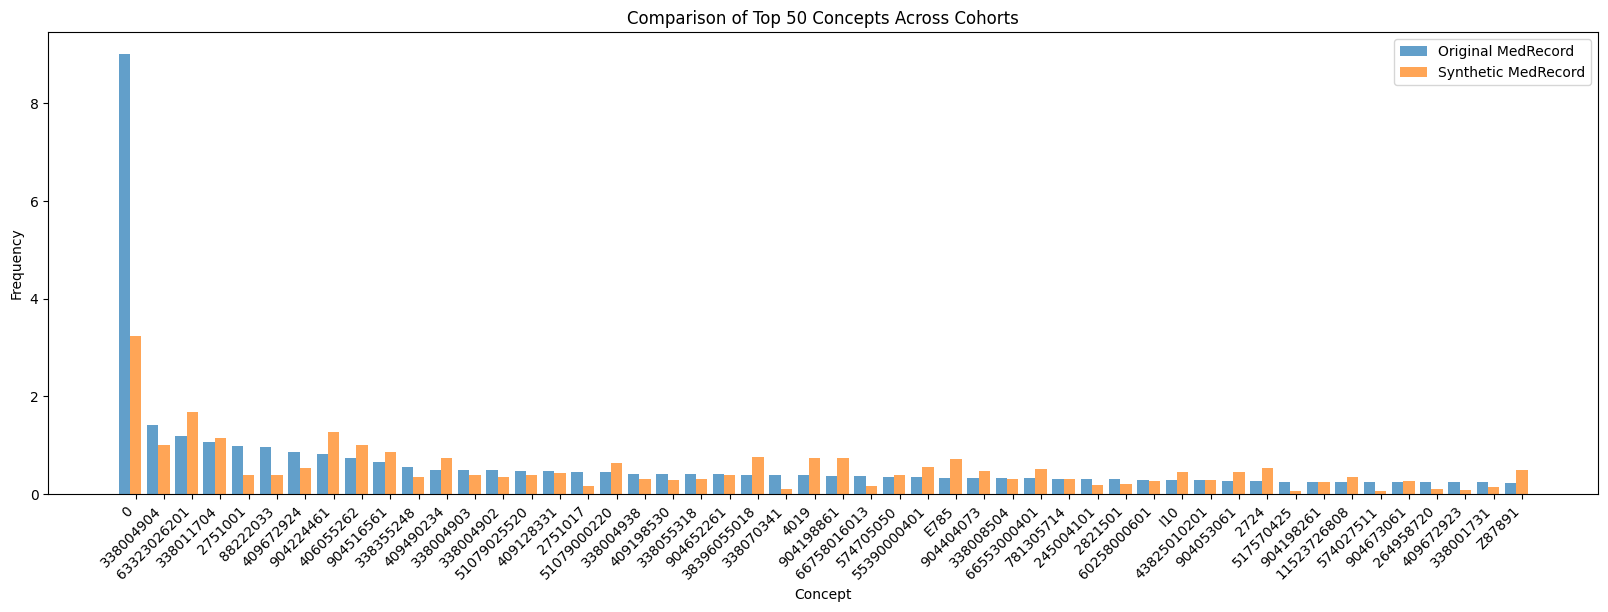

In [55]:
fig, axes = CohortComparer.plot_top_k_concepts(
    cohorts=[evaluator_mimic, evaluator_synthetic], top_k=50
)

## Calculate the absolute relative difference

This is done only using the "Continuous" attributes

In [56]:
# calculate absolute relative difference in continuous cohort attributes
CohortComparer.calculate_absolute_relative_difference(
    evaluator_mimic, evaluator_synthetic
)

(6.720954935752892, {'anchor_age': 6.720954935752892})